In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, fbeta_score, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [15]:
train = pd.read_csv("train_dataset_final1.csv")
val = pd.read_csv("validate_dataset_final.csv")

print("Train Shape:", train.shape)
print("Validation Shape:", val.shape)

Train Shape: (25247, 27)
Validation Shape: (5016, 26)


In [16]:
#Initial Inspection
print(train.head())
print(train["next_month_default"].value_counts())

val_ids = val["Customer_ID"]
train.drop("Customer_ID", axis=1, inplace=True)
val.drop("Customer_ID", axis=1, inplace=True)

   Customer_ID  marriage  sex  education  LIMIT_BAL   age  pay_0  pay_2  \
0         5017         2    0          2      60000  25.0      2      2   
1         5018         2    1          1     290000  24.0      0      0   
2         5019         1    0          2     180000  63.0      0      0   
3         5020         1    1          2     210000  43.0      0      0   
4         5021         2    0          1     280000  32.0     -2     -2   

   pay_3  pay_4  ...  Bill_amt6  pay_amt1  pay_amt2  pay_amt3  pay_amt4  \
0      2      0  ...   20750.63   2000.21      0.00   1134.85   1821.78   
1     -2     -2  ...    1350.30      0.00      0.17      0.00   2700.10   
2      0      0  ...   52991.51   2086.94   2199.99   1845.66   2000.35   
3      0      0  ...   76945.47   3348.07   3380.91   3400.45   2683.97   
4     -2     -2  ...       1.35    999.78   3186.27  45027.78   2100.09   

   pay_amt5  pay_amt6  AVG_Bill_amt  PAY_TO_BILL_ratio  next_month_default  
0   1500.03   1500.24

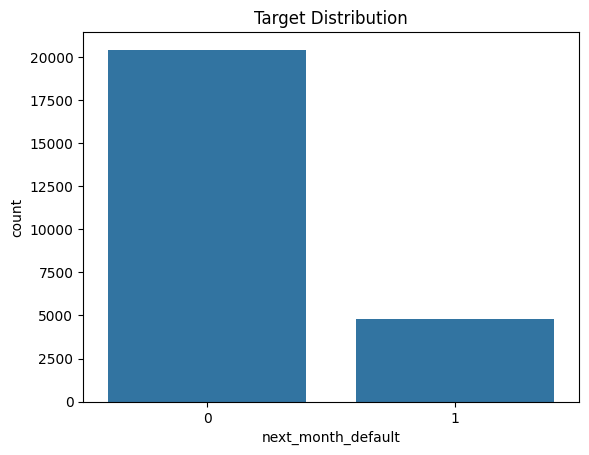

In [17]:
#Extended Exploratory Data Analysis (EDA)

# Target distribution
sns.countplot(data=train, x="next_month_default")
plt.title("Target Distribution")
plt.show()

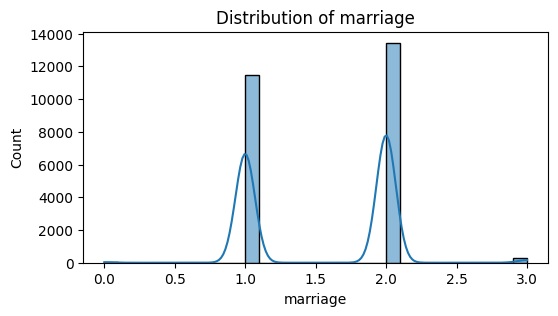

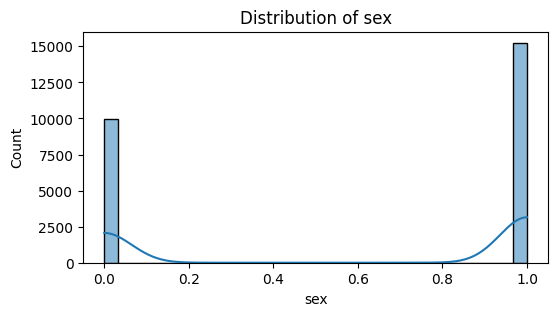

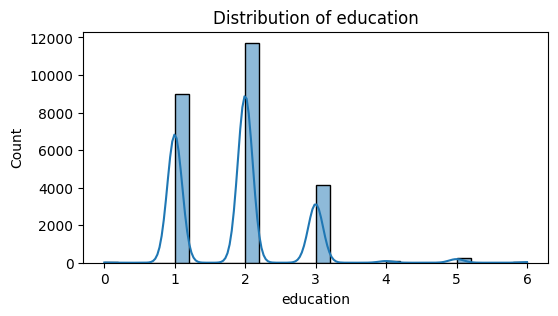

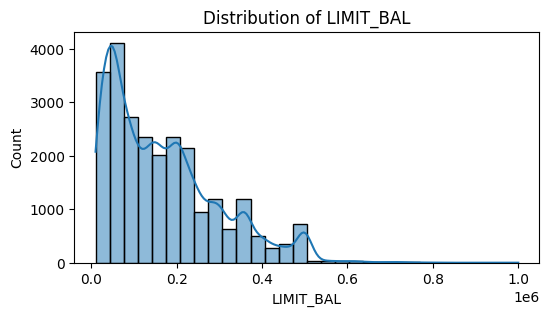

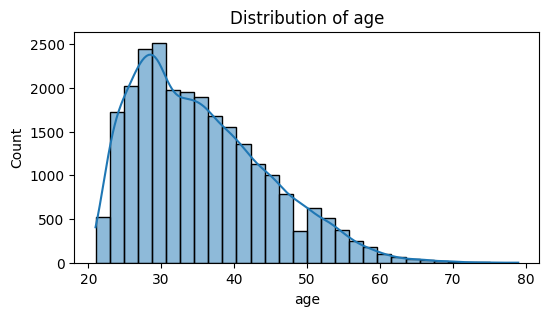

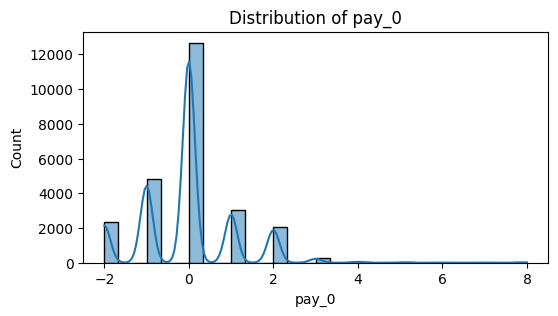

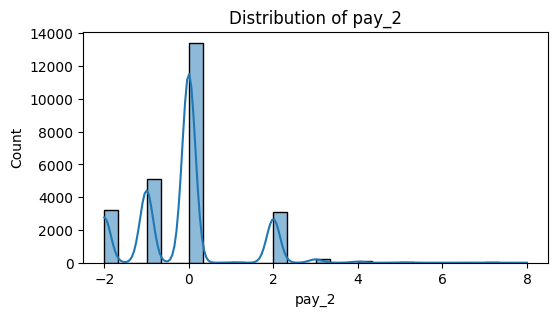

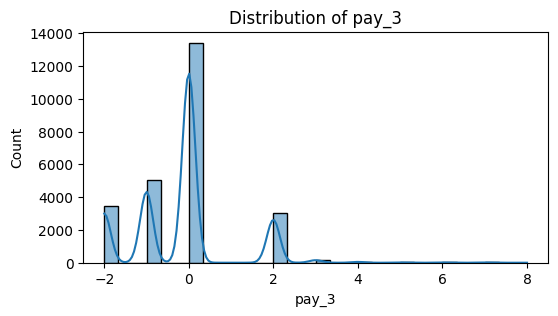

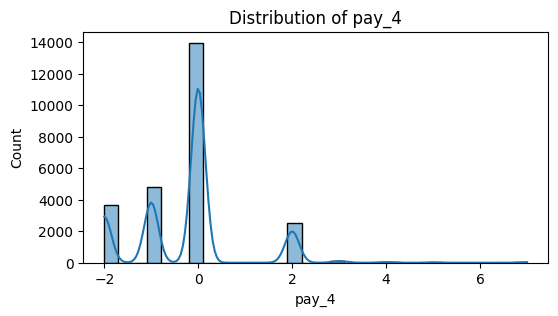

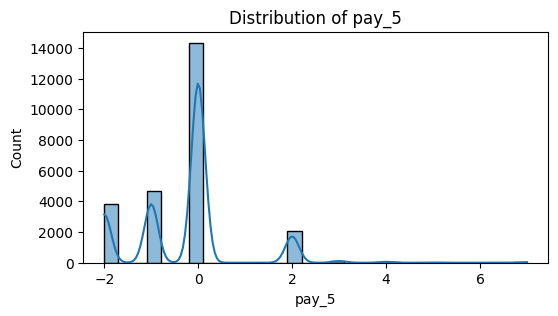

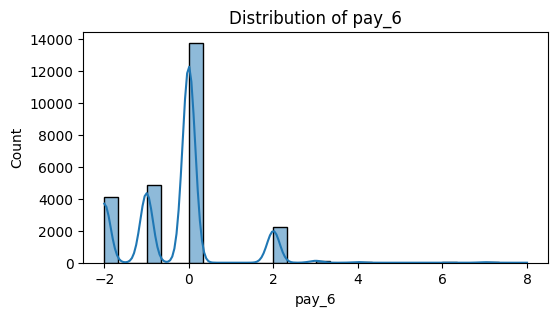

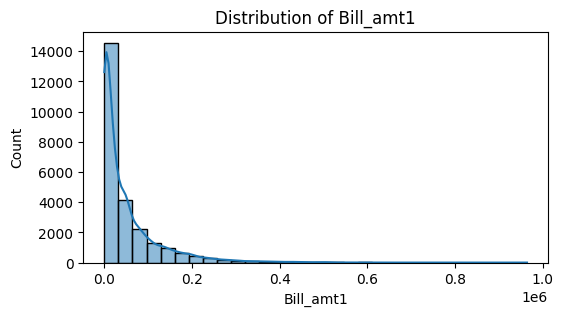

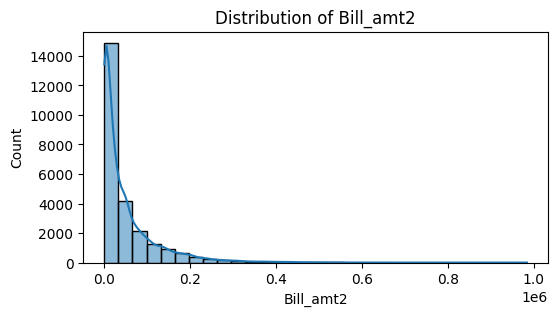

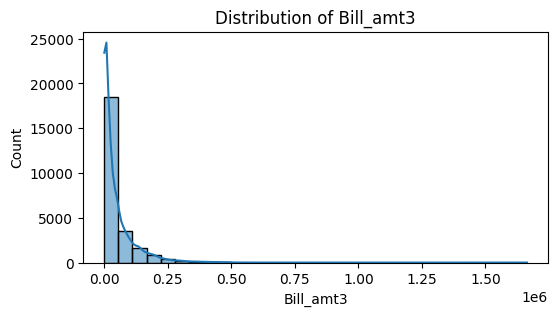

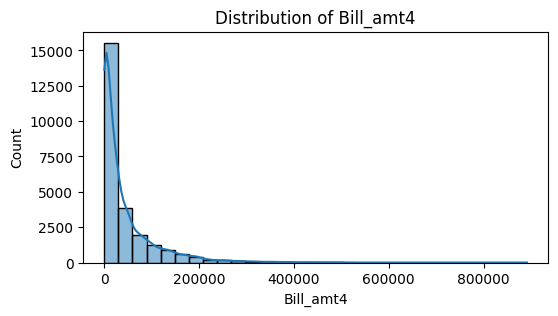

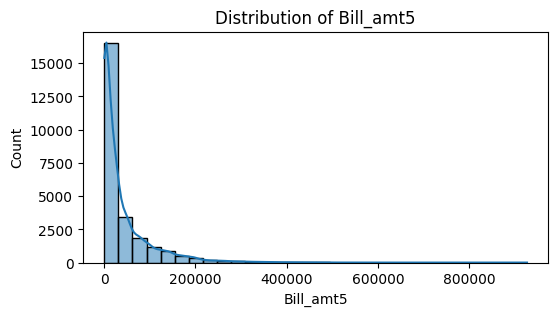

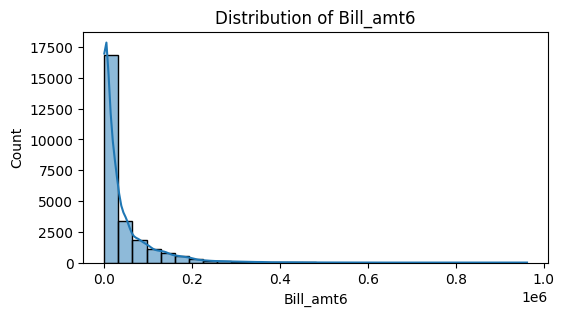

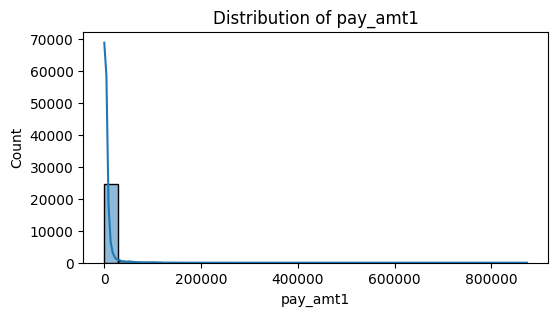

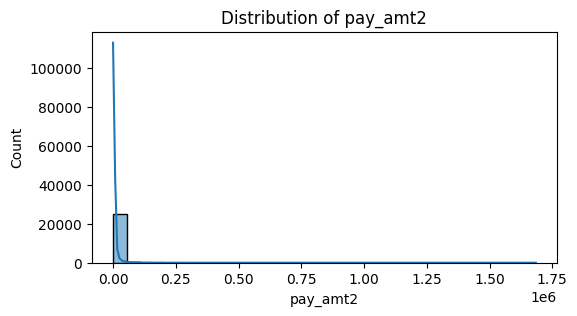

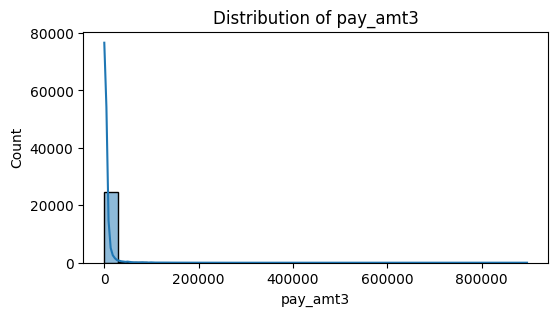

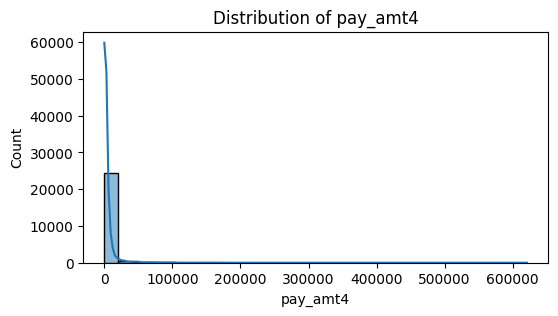

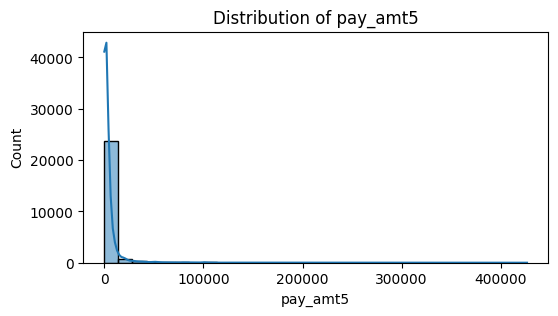

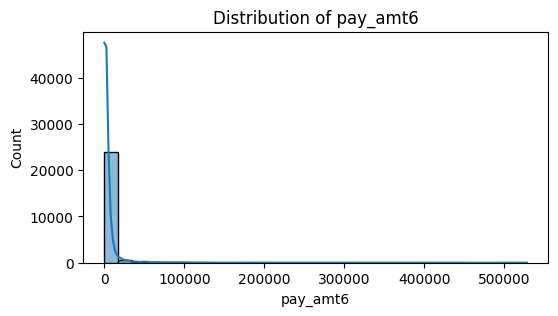

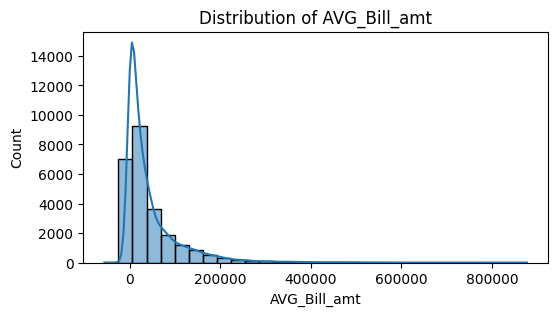

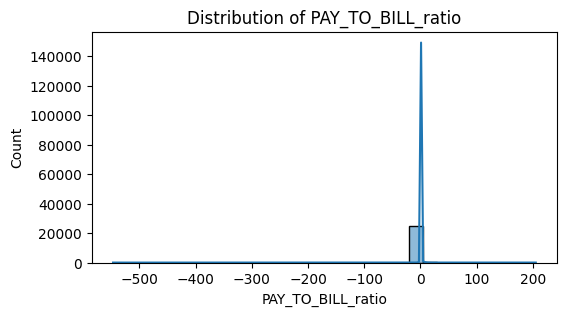

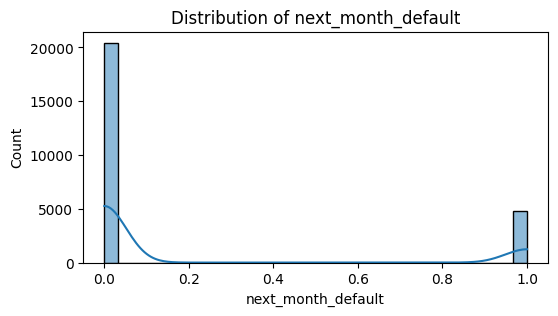

In [18]:
# Univariate distributions
numerics = train.select_dtypes(include=[np.number]).columns.tolist()
for col in numerics:
    plt.figure(figsize=(6, 3))
    sns.histplot(train[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

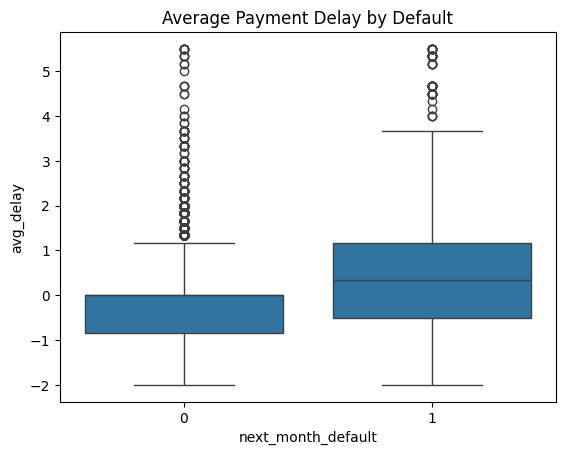

In [19]:
# Payment delay trend
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
train['avg_delay'] = train[pay_cols].mean(axis=1)
sns.boxplot(x="next_month_default", y="avg_delay", data=train)
plt.title("Average Payment Delay by Default")
plt.show()

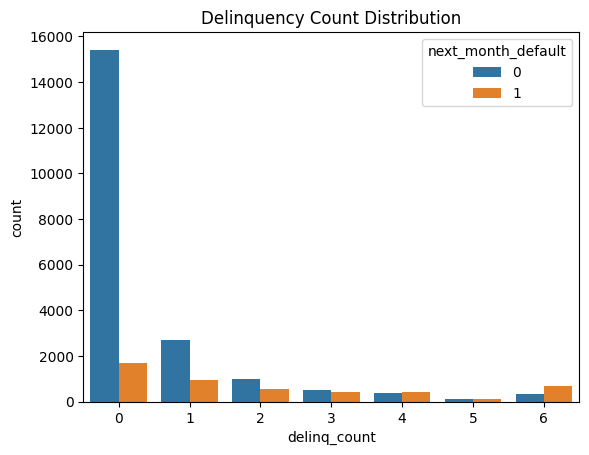

In [20]:
# Delinquency streak distribution
train['delinq_count'] = train[pay_cols].apply(lambda row: sum(row >= 1), axis=1)
sns.countplot(data=train, x='delinq_count', hue='next_month_default')
plt.title("Delinquency Count Distribution")
plt.show()


In [21]:
#Step 5: Preprocessing & Feature Engineering
def preprocess(df):
    df = df.copy()
    df['sex'] = df['sex'].astype('category')
    df['marriage'] = df['marriage'].astype('category')
    df['education'] = df['education'].astype('category')

    bill_cols = [f"Bill_amt{i}" for i in range(1, 7)]
    pay_cols = [f"pay_amt{i}" for i in range(1, 7)] # These are payment amounts
    pay_status = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'] # These are payment statuses (delays)

    df['avg_bill'] = df[bill_cols].mean(axis=1)
    df['avg_pay'] = df[pay_cols].mean(axis=1)
    # Add a small constant to the denominator to avoid division by zero
    df['pay_to_bill_ratio'] = df['avg_pay'] / (df['avg_bill'].abs() + 1)
    # Add a small constant to the denominator to avoid division by zero
    df['utilization'] = df['avg_bill'] / (df['LIMIT_BAL'] + 1)

    # Calculate the features that were previously only computed for EDA on 'train'
    df['avg_delay'] = df[pay_status].mean(axis=1)
    df['delinq_count'] = df[pay_status].apply(lambda row: sum(row >= 1), axis=1)


    df['payment_delay_mean'] = df[pay_status].mean(axis=1)
    # Calculate repayment consistency using pay_cols (payment amounts)
    df['repayment_consistency'] = df[pay_cols].std(axis=1).fillna(0) # Fill NaN for rows with no variance
    df['num_delinquent'] = df[pay_status].apply(lambda x: sum(x >= 1), axis=1)
    df['max_delinquency'] = df[pay_status].max(axis=1)

    df['log_LIMIT_BAL'] = np.log1p(df['LIMIT_BAL'])

    return df

train = preprocess(train)
val = preprocess(val)

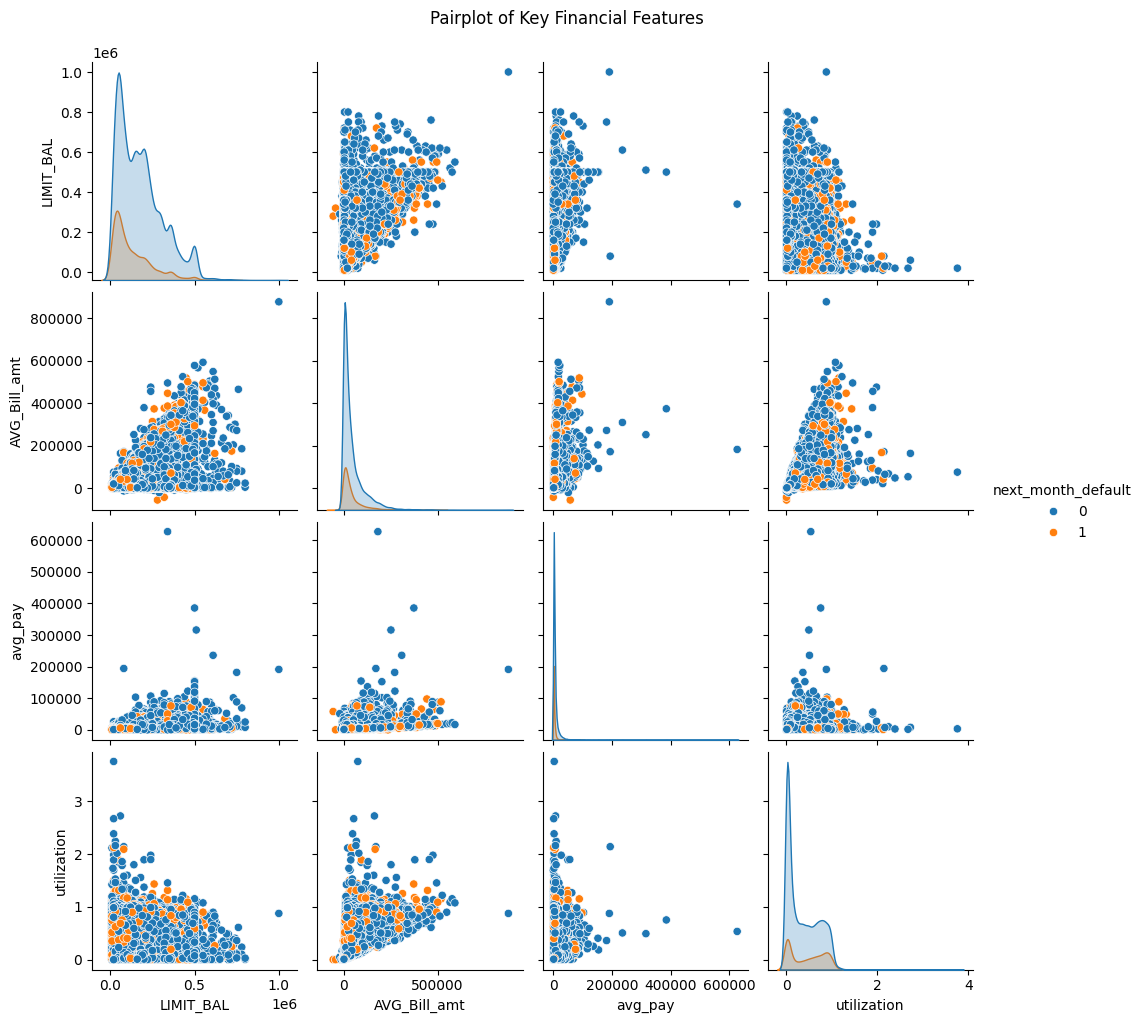

In [22]:

# Scatterplot matrix for important features — placed after feature engineering
selected = ['LIMIT_BAL', 'AVG_Bill_amt', 'avg_pay', 'utilization']
sns.pairplot(train[selected + ['next_month_default']], hue='next_month_default')
plt.suptitle("Pairplot of Key Financial Features", y=1.02)
plt.show()

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Create pipeline for imputation + scaling
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Handle any missing values
    ('scaler', StandardScaler())                  # Standardize features
])

# Split the data
X = train.drop("next_month_default", axis=1)
y = train["next_month_default"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit-transform train, transform test and val
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)
val_scaled = pipeline.transform(val[X_train.columns])  # Ensure column order

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [24]:
 #Model Training & Comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced'),
    "XGBoost": XGBClassifier(eval_metric='logloss', scale_pos_weight=1.5, use_label_encoder=False, max_depth=5, n_estimators=150),
    "LightGBM": LGBMClassifier(num_leaves=31, n_estimators=150)
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test_scaled)
    proba = model.predict_proba(X_test_scaled)[:,1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1": f1_score(y_test, preds),
        "F2": fbeta_score(y_test, preds, beta=2),
        "AUC": roc_auc_score(y_test, proba)
    }
    print(f"\n{name} Classification Report:\n", classification_report(y_test, preds, digits=3))

results_df = pd.DataFrame(results).T
print("\nModel Comparison:\n", results_df.sort_values(by="F2", ascending=False))

     


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0      0.900     0.795     0.844      4088
           1      0.418     0.624     0.500       962

    accuracy                          0.763      5050
   macro avg      0.659     0.710     0.672      5050
weighted avg      0.808     0.763     0.779      5050


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0      0.858     0.795     0.825      4088
           1      0.337     0.442     0.382       962

    accuracy                          0.728      5050
   macro avg      0.597     0.618     0.604      5050
weighted avg      0.759     0.728     0.741      5050


Random Forest Classification Report:
               precision    recall  f1-score   support

           0      0.888     0.854     0.871      4088
           1      0.466     0.542     0.501       962

    accuracy                          0.794      5050
   ma

In [25]:
#Final Model Selection & Prediction
best_model = models[results_df.sort_values(by="F2", ascending=False).index[0]]
best_model.fit(X_train_res, y_train_res)
val_preds = best_model.predict_proba(val_scaled)[:, 1]

# Optimize threshold using F2
prec, rec, thresholds = precision_recall_curve(y_test, best_model.predict_proba(X_test_scaled)[:,1])
f2_scores = 5 * (prec * rec) / (4 * prec + rec + 1e-6)
opt_threshold = thresholds[np.argmax(f2_scores)]
print("Best F2 Threshold:", opt_threshold)

final_preds = (val_preds >= opt_threshold).astype(int)

Best F2 Threshold: 0.37831056372849675


In [26]:
submission = pd.DataFrame({
    "Customer": val_ids,
    "next_month_default": final_preds
})

submission.to_csv("submission_23117148.csv", index=False)
print("result saved.")

result saved.
